In [1]:

import numpy as np
import pandas as pd
import os
import PIL # install pillow - pip install Pillow
import PIL.Image
import tensorflow as tf
#from tensorflow import keras
import tensorflow_datasets as tfds # need to install this seperately - pip install tensorflow_datasets
import pathlib
from skimage import io
import datetime
import matplotlib.pyplot as plt
import h5py # pip install h5py
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.gridspec as gridspec
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import glob
import os
import shutil

c:\Users\chaba\OneDrive\Skrivebord\MAS512_local\python_venvs\MAS512_G_2024_AUTUMN\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# copy .csv files from one location to other
# use only once when you need to add new class

In [2]:
# copy .csv files from one location to other
#use only once when you need to add new class


# src_folder = r"C:\Users\ajitj\OneDrive - Universitetet i Agder\PhD_Research\Paper_Writing\Textile Sorting\Data_textile_NIRSCAN\ML_textile_classification_timeseries\Data_NIRSCAN_CSV\polyester-000011\polyester-000011"
# dst_folder = r"C:\Users\ajitj\OneDrive - Universitetet i Agder\PhD_Research\Paper_Writing\Textile Sorting\Data_textile_NIRSCAN\ML_textile_classification_timeseries\data_ml\polyester"

# # Search files with .txt extension in source directory
# pattern = "\*.csv"
# files = glob.glob(src_folder + pattern)

# # move the files with txt extension
# for file in files:
#     # extract file name form file path
#     file_name = os.path.basename(file)
#     shutil.move(file, dst_folder + file_name)
#     #print('Moved:', file)

# Use this to generate .csv file for ml. Use only once to generate data_cotton_wool_polyester.csv

In [19]:
# Define base path and subfolders
BASE_PATH = r'C:\Users\chaba\OneDrive\Skrivebord\MAS513_local\Textile_sorting\Project\textile_sorting_NIRSCAN_\samples'
MATERIALS = ["cotton", "wool", "polyester"]
PATHS = {material: os.path.join(BASE_PATH, material, "**", "*.csv") for material in MATERIALS}

# Function to read and process data
def read_data(path):
    files = glob.glob(path, recursive=True)  # Use glob to find all matching CSV files
    if not files:
        raise FileNotFoundError(f"No files found at {path}")

    appended_data = []
    for filename in files:
        # Read CSV file
        df = pd.read_csv(filename, header=21)
        # Clean and normalize the data
        df['wavelength'] = pd.to_numeric(df['Wavelength (nm)'], errors='coerce')
        df['absorbance'] = pd.to_numeric(df['Absorbance (AU)'], errors='coerce')
        df['absorbance'] /= np.max(df['absorbance'])
        # Drop unnecessary columns
        df = df.drop(['wavelength', 'Absorbance (AU)', 
                      'Reference Signal (unitless)', 
                      'Sample Signal (unitless)', 
                      'Wavelength (nm)'], axis=1)
        # Transpose data and append
        appended_data.append(df.T)

    # Combine all data into a single DataFrame
    return pd.concat(appended_data, ignore_index=True)

# Process data for each material
dataframes = []
classes = {material: i for i, material in enumerate(MATERIALS)}

for material, path in PATHS.items():
    print(f"Processing {material} data from: {path}")
    try:
        appended_data = read_data(path)
        material_class = np.full(len(appended_data), classes[material], dtype=int)  # Assign class
        appended_data.insert(appended_data.shape[1], "class", material_class)
        dataframes.append(appended_data)
        print(f"{material.capitalize()} data loaded: {len(appended_data)} samples.")
    except FileNotFoundError as e:
        print(f"Warning: {e}")

# Concatenate all dataframes
if dataframes:
    data = pd.concat(dataframes, ignore_index=True)
else:
    raise ValueError("No data found for any material. Please check your paths and files.")

# Save concatenated data to a single CSV
output_path = os.path.join(BASE_PATH, 'data_cotton_wool_polyester.csv')
data.to_csv(output_path, index=False)
print(f"Data saved to {output_path}")

# Class distribution
print("Class distribution:")
print(data['class'].value_counts())

# Save per-material CSVs (optional)
for material, df in zip(MATERIALS, dataframes):
    material_path = os.path.join(BASE_PATH, f"data_{material}.csv")
    df.to_csv(material_path, index=False)
    print(f"{material.capitalize()} data saved to {material_path}")


Processing cotton data from: C:\Users\chaba\OneDrive\Skrivebord\MAS513_local\Textile_sorting\Project\textile_sorting_NIRSCAN_\samples\cotton\**\*.csv
Cotton data loaded: 1000 samples.
Processing wool data from: C:\Users\chaba\OneDrive\Skrivebord\MAS513_local\Textile_sorting\Project\textile_sorting_NIRSCAN_\samples\wool\**\*.csv
Wool data loaded: 1000 samples.
Processing polyester data from: C:\Users\chaba\OneDrive\Skrivebord\MAS513_local\Textile_sorting\Project\textile_sorting_NIRSCAN_\samples\polyester\**\*.csv
Polyester data loaded: 1000 samples.
Data saved to C:\Users\chaba\OneDrive\Skrivebord\MAS513_local\Textile_sorting\Project\textile_sorting_NIRSCAN_\samples\data_cotton_wool_polyester.csv
Class distribution:
class
0    1000
1    1000
2    1000
Name: count, dtype: int64
Cotton data saved to C:\Users\chaba\OneDrive\Skrivebord\MAS513_local\Textile_sorting\Project\textile_sorting_NIRSCAN_\samples\data_cotton.csv
Wool data saved to C:\Users\chaba\OneDrive\Skrivebord\MAS513_local\Text

# Use this code to load data_cotton_wool_polyester.csv

In [21]:
data = pd.read_csv('data_cotton_wool_polyester.csv')
#read cotton file, to extract wavelength value. This is same for all acq
path_c = r'C:\Users\chaba\OneDrive\Skrivebord\MAS513_local\Textile_sorting\Project\textile_sorting_NIRSCAN_\samples\cotton\cotton-000261\Column 1_043007_20240418_105144.csv'
data_c = pd.read_csv(path_c, header=21)
wavelength = data_c['Wavelength (nm)']
wavelength = np.around(wavelength) #truncate to 1 dec place
wavelength = wavelength.to_numpy()


In [22]:
wavelength[-1]

1701.0

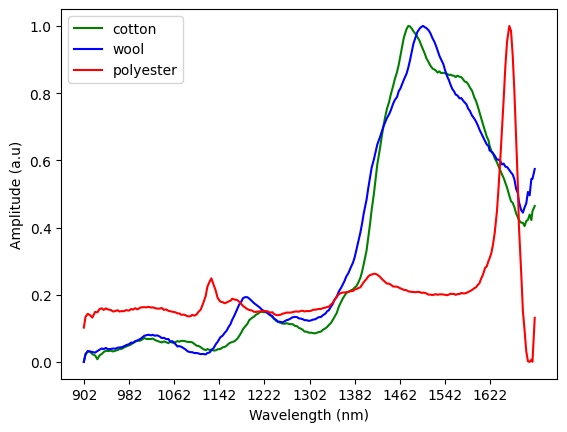

In [26]:

cotton_portion=data[0:int(np.shape(data)[0]/3)] #900x229; 900 data samples (acq), 0:227 data, 228 label data frame; data --1800x229
wool_portion=data[int(np.shape(data)[0]/3):2*int(np.shape(data)[0]/3)]
polyester_portion=data[2*int(np.shape(data)[0]/3)::]

#normalize spectral data
cp=cotton_portion.iloc[0][0:228]
wp=wool_portion.iloc[0][0:228]
pp=polyester_portion.iloc[0][0:228]

cp_n=(cp-np.min(cp))/(np.max(cp)-np.min(cp))
wp_n=(wp-np.min(wp))/(np.max(wp)-np.min(wp))
pp_n=(pp-np.min(pp))/(np.max(pp)-np.min(pp))

plt.figure(1)
#plt.title('Data')
plt.plot(wavelength,cp_n,'g', label='cotton') #cotton_portion.iloc[0][0:228]
plt.plot(wavelength,wp_n,'b', label='wool')
plt.plot(wavelength,pp_n,'r', label='polyester')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Amplitude (a.u)')
# Change x-axis tick spacing
plt.xticks(np.arange(wavelength[0], wavelength[-1], step=80))  # ticks at 0, 2, 4, ..., 10
plt.legend()
plt.show()


In [27]:
cp=cotton_portion.iloc[0][0:228]
cp_n=(cp-np.mean(cp))/np.std(cp)
cp_n

0     -1.038446
1     -0.965672
2     -0.948475
3     -0.947178
4     -0.968968
         ...   
223    0.224516
224    0.270548
225    0.221626
226    0.300617
227    0.346696
Name: 0, Length: 228, dtype: float64

In [173]:
# def read_data(path):
#     appended_data = []
#     df = [pd.read_csv(filename,header=21) for filename in glob.glob(path)] 
#     peak_abs=np.zeros((np.shape(df)[0]))
#     for file in range(np.shape(df)[0]):
#         #df[file][['wavelength','absorbance', 'reference', 'sample_signal']]=df[file]['data'].str.split(expand=True)
#         df[file]['wavelength'] = pd.to_numeric(df[file]['Wavelength (nm)'], errors='coerce')
#         df[file]['absorbance'] = pd.to_numeric(df[file]['Absorbance (AU)'], errors='coerce')
#         df[file]['absorbance']=df[file]['absorbance']/np.max(df[file]['absorbance'])
#          # remove data col, as not needed
#         df[file]=df[file].drop(['Absorbance (AU)', 'Reference Signal (unitless)', 'Sample Signal (unitless)', 'Wavelength (nm)'], axis=1)
#         appended_data.append(df[file])
#         peak_abs[file]=df[file]['wavelength'][np.argmax(df[file]['absorbance'])]
#     appended_data = pd.concat(appended_data) # all 900 acquisition appended together
#     #appended_data_coton.to_excel('appended.xlsx') # write to csv    
#     return df, appended_data, peak_abs



# def read_data(path):
#     append_files=[]
#     for file in range(np.shape(df_cotton)[0]):
#         df_cotton[file] = pd.DataFrame(df_cotton[file])
#         #df_cotton[file]=df_cotton[file].drop(['wavelength'], axis=1)
#         append_files_cotton.append(df_cotton[file].T) #228x1
#     append_files_cotton = pd.concat(append_files_cotton) # all 900 acquisition appended together
#     append_files_cotton.to_csv('df_cotton.csv', index=False)




# path_cotton=r'C:\Users\ajitj\OneDrive - Universitetet i Agder\PhD_Research\Paper_Writing\Textile Sorting\Data_textile_NIRSCAN\ML_textile_classification_timeseries\train\cotton\*.csv' # path of file to read
# df_cotton, appended_data_cotton, peak_abs_cotton =read_data(path_cotton) # read file 1000x227x4
# class_cotton=np.zeros(len(appended_data_cotton)).astype(int)
# appended_data_cotton.insert(2, "class", class_cotton)

In [211]:
# np.shape(df_cotton), np.shape(appended_data_cotton), 

# append_files_cotton=[]
# #convert df_cotton from list to pd dataframe, save it as csv
# for file in range(np.shape(df_cotton)[0]):
#     df_cotton[file] = pd.DataFrame(df_cotton[file])
#     #df_cotton[file]=df_cotton[file].drop(['wavelength'], axis=1)
#     append_files_cotton.append(df_cotton[file].T) #228x1
# append_files_cotton = pd.concat(append_files_cotton) # all 900 acquisition appended together
# append_files_cotton.to_csv('df_cotton.csv', index=False)

 # Use this to read csv files and do ml. Use this ONLY when the data is  saved as .csv

In [28]:
#use this to read csv files and onwards
data = pd.read_csv(r'samples\data_cotton_wool_polyester.csv')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,class
0,0.943625,0.952614,0.956555,0.948241,0.937438,0.937375,0.955793,0.944125,0.944394,0.940248,...,0.975457,0.996889,0.966193,1.000000,0.950199,0.947629,0.917950,0.984184,0.991565,3
1,0.932569,0.924713,0.949718,0.949558,0.934567,0.938890,0.957081,0.943079,0.943547,0.948631,...,0.972850,0.954453,0.969735,0.945478,0.979529,0.989339,0.952550,1.000000,0.982147,3
2,0.898996,0.908585,0.908086,0.913989,0.904948,0.896533,0.902713,0.908785,0.902858,0.912653,...,0.936595,0.925604,0.915673,0.993804,0.959361,1.000000,0.918890,0.908160,0.876784,3
3,0.941178,0.957887,0.953722,0.955658,0.948133,0.958803,0.946439,0.964691,0.962392,0.958350,...,0.979766,0.954947,0.993311,0.948810,0.979149,0.960857,0.922080,1.000000,0.967142,3
4,0.895839,0.903789,0.899827,0.897297,0.874924,0.898105,0.890846,0.882330,0.888910,0.889721,...,0.913787,0.975278,0.909130,0.965942,0.907321,0.949962,0.926966,1.000000,0.843531,3


In [29]:
# train test data set

# train_df, val_df = train_test_split(data, test_size=0.20)
# train_df, test_df = train_test_split(train_df, test_size=0.1)

# #training, val and test data size
# print ("Train shape: {} \n Val shape: {} \n Test shape: {} \n" .format(np.shape(train_df), np.shape(val_df), np.shape(test_df))) 
# #np.array( [np.shape(train_df)[0], np.shape(val_df)[0], np.shape(val_df)[0] ]) /np.array([np.shape(data)[0]])
# # train, val, test - 70, 20, 10

# #save to csv
# #data.to_csv('data_cotton_wool.csv', index=False)  

# #check
# data['class'].value_counts()

In [30]:
# train, test split 

y = data['class']
x = data.drop(columns=['class'])
#x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.20,random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=40)


print("Train: \n {}\n".format(y_train.value_counts()))
print("Val: \n {} \n".format(y_val.value_counts()))
print("Test: \n {} \n".format(y_test.value_counts()))

print("Train: \n {} {}\n".format(np.shape(x_train), np.shape(y_train)))
print("Val: \n {} {}\n".format(np.shape(x_val), np.shape(y_val)))
print("Test: \n {} {}\n".format(np.shape(x_test), np.shape(y_test)))

# Train: (1440, 228) (1440,)

#Val: (360, 228) (360,)


Train: 
 class
3    720
Name: count, dtype: int64

Val: 
 class
3    200
Name: count, dtype: int64 

Test: 
 class
3    80
Name: count, dtype: int64 

Train: 
 (720, 228) (720,)

Val: 
 (200, 228) (200,)

Test: 
 (80, 228) (80,)



In [35]:
# Check few samples
# Find indices for labels 0 (cotton), 1 (wool), and 2 (polyester) in training and validation data
y_train_0 = np.where(y_train == 0)[0]  # Index for cotton
y_train_1 = np.where(y_train == 1)[0]  # Index for wool
y_train_2 = np.where(y_train == 2)[0]  # Index for polyester

y_val_0 = np.where(y_val == 0)[0]  # Index for cotton in validation set
y_val_1 = np.where(y_val == 1)[0]  # Index for wool in validation set
y_val_2 = np.where(y_val == 2)[0]  # Index for polyester in validation set

# Check if there are samples available for each class
if len(y_train_0) == 0 or len(y_train_1) == 0 or len(y_train_2) == 0:
    raise ValueError("One or more classes are missing in the training set!")

# Plot absorbance values for the first sample of each class in the training set
plt.figure(figsize=(10, 6))
plt.title('Data')
plt.plot(x_train.iloc[y_train_0[0]], 'g', label='cotton')  # Cotton sample
plt.plot(x_train.iloc[y_train_1[0]], 'b', label='wool')    # Wool sample
plt.plot(x_train.iloc[y_train_2[0]], 'r', label='polyester')  # Polyester sample
plt.xlabel('Wavelength Index')
plt.ylabel('Absorbance')
plt.legend()
plt.show()


ValueError: One or more classes are missing in the training set!

In [85]:
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS):
  
  # model1 = tf.keras.Sequential([
  #     tf.keras.layers.Dense(
  #         16, activation='relu',
  #         input_shape=(x_train.shape[-1],)),
  #     tf.keras.layers.Dropout(0.5),
  #     tf.keras.layers.Dense(1, activation='sigmoid'),
  # ])

  model=tf.keras.Sequential([
    
  #tf.keras.layers.experimental.preprocessing.Rescaling(scale=1 / 127.5, input_shape=(n_row, n_col, 3), offset=-1),
  #tf.keras.layers.Dense(228, activation='relu',input_shape=(x_train.shape[-1],)),
  tf.keras.layers.Conv1D(8, kernel_size=8, input_shape=(x_train.shape[-1],1), strides=1,  activation='relu'),  
  tf.keras.layers.MaxPooling1D(pool_size=2),
  tf.keras.layers.Conv1D(16, 8, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling1D(pool_size=2),
  
  tf.keras.layers.Conv1D(32, 8, padding="same", activation="relu"), 
  
  #tf.keras.layers.Conv1D(64, 3, padding="same", activation="relu"),
  #tf.keras.layers.MaxPooling1D(pool_size=2),
  #tf.keras.layers.Conv1D(64, 3, padding="same", activation="relu"),
  #tf.keras.layers.MaxPooling1D(pool_size=2),

  #tf.keras.layers.Conv1D(64, 3, activity_regularizer=tf.keras.regularizers.L2(0.01),padding="same", activation="relu"),
  tf.keras.layers.MaxPooling1D(pool_size=2),

  tf.keras.layers.Flatten(),

  # tf.keras.layers.Dense(64, 
  # activity_regularizer=tf.keras.regularizers.L2(0.01),
  # activation='relu'),

  tf.keras.layers.Dense(
      64, 
      #activity_regularizer=tf.keras.regularizers.L2(0.01),
      activation='relu'),
  tf.keras.layers.Dropout(0.2),
  #tf.keras.layers.Dense(1, activation='sigmoid'),
  tf.keras.layers.Dense(3, activation='softmax'),
    ])

  model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # use false when we have softmax at last layer
        metrics=metrics)

  return model

EPOCHS = 30 #50
BATCH_SIZE = 32

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_prc', 
#     verbose=1,
#     patience=10,
#     mode='max',
#     restore_best_weights=True)

model = make_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 221, 8)            72        
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 110, 8)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 110, 16)           1040      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 55, 16)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 55, 32)            4128      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 27, 32)          

In [ ]:
log_path=r'\scripts\model\logs'

ap_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_save_path = os.path.join(log_path, f"trained_model_{ap_name}.h5")

# Define TensorBoard log directory
log_dir = os.path.join(log_path, f"logs_{ap_name}")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
       #log_dir=log_dir, 
       histogram_freq=1,
       write_graph=False,
       write_images=False, #write model weights to visualize as image in TensorBoard.
       write_steps_per_second=False,
       update_freq='epoch', #'batch'
       profile_batch=0,
       embeddings_freq=0,
       embeddings_metadata=None,
       #**kwargs
)

#convert to one hot encoding

enc = OneHotEncoder()
#x_train_ohe = enc.fit_transform(np.asarray(x_train).astype('float32').reshape((-1,1))).toarray()
#x_val_ohe = enc.fit_transform(np.asarray(x_val).astype('float32').reshape((-1,1))).toarray() 
y_train_ohe = enc.fit_transform(np.asarray(y_train).astype('float32').reshape((-1,1))).toarray() 
y_val_ohe = enc.fit_transform(np.asarray(y_val).astype('float32').reshape((-1,1))).toarray()
y_test_ohe = enc.fit_transform(np.asarray(y_test).astype('float32').reshape((-1,1))).toarray()


history=model.fit(
 x_train,
 y_train_ohe,
 validation_data=(x_val, y_val_ohe),
 epochs=EPOCHS,
 verbose=1,
 callbacks=[tensorboard_callback]
)
# Save the trained model
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

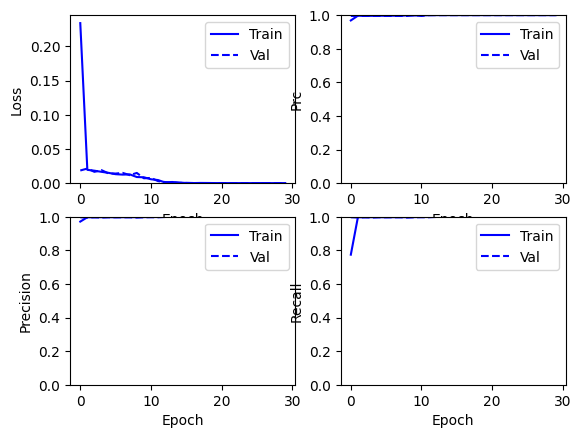

In [87]:
#plot training history

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  colors=['b', 'g']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

8/8 [==============================] - 0s 2ms/step
loss :  2.8315089366515167e-06
cross entropy :  2.8315089366515167e-06
Brier score :  7.156504291353383e-15
tp :  600.0
fp :  0.0
tn :  1200.0
fn :  0.0
accuracy :  1.0
precision :  1.0
recall :  1.0
auc :  1.0
prc :  1.0

Legitimate Transactions Detected (True Negatives):  73
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  83
Total Fraudulent Transactions:  83
Classification report : 
               precision    recall  f1-score   support

      Cotton       1.00      1.00      1.00        73
        Wool       1.00      1.00      1.00        83
   Polyester       1.00      1.00      1.00        84

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



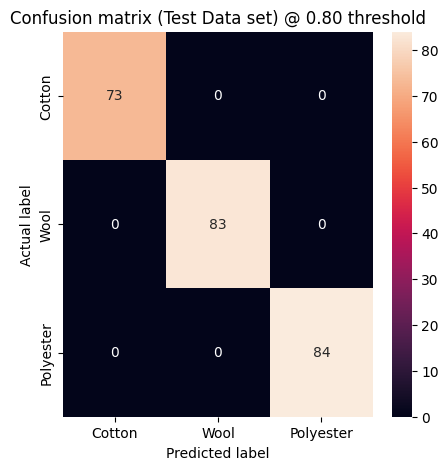

In [88]:
#confusion matrix


test_predictions_baseline = model.predict(x_test, batch_size=BATCH_SIZE)
class_names=['Cotton', 'Wool', 'Polyester']
threshold=0.8

def plot_cm(labels, predictions, class_names, threshold):
  predictions > threshold
  np.argmax(predictions, axis=1)
  predicted_label=np.argmax(predictions, axis=1)
  
  cm = confusion_matrix(labels,predicted_label ) #predictions > threshold
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #normalized cm
  
  plt.figure(figsize=(5,5))
  #sns.heatmap(cm, annot=True, fmt="d")
  #plt.subplot(2,1,1)
  #sns.heatmap(cmn, annot=True, fmt=".2f", xticklabels=class_names, yticklabels=class_names) 
 
  # plt.subplot(2,1,2)
  sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
  
  plt.title('Confusion matrix (Test Data set) @ {:.2f} threshold'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

  print('Classification report : \n',classification_report(y_test, predicted_label, target_names=class_names)) #true_label, predicted_label

baseline_results = model.evaluate(x_val, y_val_ohe,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline, class_names, threshold)

